In [1]:
from __future__ import division
import gc
import os
import time
import sys
import random
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import clear_output
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

import torchvision.utils as vutils
import torchvision.transforms as transforms


In [2]:
class ImageBuffer:
    """Fixed-size buffer to store image tuples."""

    def __init__(self, buffer_size):
        """Initialize a ImageBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.images = namedtuple("Images", field_names=['real_image_X', 'fake_image_X', 
                                                        'real_image_Y', 'fake_image_Y'])
    
    def add(self, real_image_X, fake_image_X, real_image_Y, fake_image_Y):
        """Add a new images to memory."""
        image_pair = self.images(real_image_X, fake_image_X.clone(), real_image_Y, fake_image_Y.clone())
        self.memory.append(image_pair)
    
    def sample(self):
        """Return a batch of image tuples from memory."""
        return self.memory.popleft()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def model_summary(model):
    print('=================================================================')
    print(model)
    print('=================================================================')
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Total params: {:,}'.format(total_params))
    print('Trainable params: {:,}'.format(trainable_params))
    print('Non-trainable params: {:,}'.format(total_params - trainable_params))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=7, strides=1, padding=0, activation=nn.ReLU):
        super(ConvBlock, self).__init__()
        self.blocks = nn.Sequential(
                                        nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                        nn.InstanceNorm2d(num_features=filters),
                                        activation(inplace=True))
    
    def forward(self, input_tensor):
        x = self.blocks(input_tensor)
        return x

class DeConvBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=7, strides=1, padding=0, output_padding=1, activation=nn.ReLU):
        super(DeConvBlock, self).__init__()
        self.blocks = nn.Sequential(
                                    nn.ConvTranspose2d(in_channels, out_channels=filters, kernel_size=kernel_size,
                                                       stride=strides, padding=padding, output_padding=output_padding),
                                    nn.InstanceNorm2d(num_features=filters),
                                    activation(inplace=True))
    
    def forward(self, input_tensor):
        x = self.blocks(input_tensor)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=3, strides=1, padding=0, activation=nn.ReLU):
        super(ResidualBlock, self).__init__()
        self.conv_blocks = nn.Sequential(
                                            nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                            nn.ReflectionPad2d(1),
                                            nn.InstanceNorm2d(num_features=filters),
                                            activation(inplace=True),
                                            nn.Conv2d(in_channels, out_channels=filters, kernel_size=kernel_size, stride=strides, padding=padding),
                                            nn.ReflectionPad2d(1),
                                            nn.InstanceNorm2d(num_features=filters))
    
    def forward(self, input_tensor):
        x = self.conv_blocks(input_tensor)
        x = x + input_tensor
        return x
    
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = None
    def forward(self, x):
        pass
    def summary(self):
        if self.model != None:
            print('=================================================================')
            print(self.model)
            print('=================================================================')
            total_params = sum(p.numel() for p in self.model.parameters())
            trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            print('Total params: {:,}'.format(total_params))
            print('Trainable params: {:,}'.format(trainable_params))
            print('Non-trainable params: {:,}'.format(total_params - trainable_params))
        else:
            print('Model not created')
    
class ResNetGenerator(BaseModel):
    def __init__(self, input_channel=3, output_channel=3, filters=64, n_blocks=9):
        super(ResNetGenerator, self).__init__()
        # Downsample layers
        layers = [
                      nn.ReflectionPad2d(3),
                      ConvBlock(in_channels=input_channel, filters=filters, kernel_size=7, strides=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters, filters=filters * 2, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 2, filters=filters * 4, kernel_size=3, strides=2, padding=1, activation=nn.LeakyReLU)
        ]
        
        # Residual layers
        for i in range(n_blocks):
            layers.append(ResidualBlock(in_channels=filters * 4, filters=filters * 4, kernel_size=3, strides=1, activation=nn.LeakyReLU))
        
        # Upsample layers
        layers += [
                        DeConvBlock(in_channels=filters * 4, filters=filters * 2, kernel_size=3, strides=2, padding=1, output_padding=1, activation=nn.LeakyReLU),
                        DeConvBlock(in_channels=filters * 2, filters=filters, kernel_size=3, strides=2, padding=1, output_padding=1, activation=nn.LeakyReLU),
                        nn.ReflectionPad2d(3),
                        nn.Conv2d(in_channels=filters, out_channels=output_channel, kernel_size=7, stride=1, padding=0)
        ]
        # Output layer
        layers += [nn.Tanh()]
        
        # Create model
        self.model = nn.Sequential(*layers)
    
    def forward(self, input_tensor):
        x = self.model(input_tensor)
        return x
    
class PatchGANDiscriminator(BaseModel):
    def __init__(self, input_channel, filters=64):
        super(PatchGANDiscriminator, self).__init__()

        layers = [
                      nn.Conv2d(in_channels=input_channel, out_channels=filters, kernel_size=4, stride=2, padding=1),
                      nn.LeakyReLU(inplace=True),
                      ConvBlock(in_channels=filters, filters=filters * 2, kernel_size=4, strides=2, padding=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 2, filters=filters * 4, kernel_size=4, strides=2, padding=1, activation=nn.LeakyReLU),
                      ConvBlock(in_channels=filters * 4, filters=filters * 8, kernel_size=4, strides=1, padding=1, activation=nn.LeakyReLU),
        ]
        # Output layer
        layers += [nn.Conv2d(in_channels=filters * 8, out_channels=1, kernel_size=4, stride=1, padding=1)]
        # Create model
        self.model = nn.Sequential(*layers)
    
    def forward(self, input_tensor):
        x = self.model(input_tensor)
        return x

In [4]:
INPUT_SHAPE = 64
SCALE_WIDTH = 64
DATASET = 'monet2photo'
DATASET_PATH = os.path.join("datasets", DATASET) # Dataset path
OUTPUT_PATH = 'outputs'
base_logdir = os.path.join("logs", 'pytorch') # Sets up a log directory.

USE_BUFFER = True # Use image buffer to train discriminator
REPLAY_PROB = 0.5 # The probability of using previous fake images to train discriminator
BUFFER_SIZE = 50 # The maximum size of image buffer
BATCH_SIZE = 1

EPOCHs = 200
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 5 # Save checkpoint at every n epoch

DISCRIMINATOR_LOSS_WEIGHT = 0.5 # Discriminator loss will be multiplied by this weight
SOFT_FAKE_LABEL_RANGE = [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.
LR = 0.0002
LR_DECAY_EPOCH = 100
LAMBDA = 10 # loss weight for cycle consistency

ngpu = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter(base_logdir)

In [5]:
G_XtoY = ResNetGenerator(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
G_YtoX = ResNetGenerator(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G_XtoY = nn.DataParallel(G_XtoY, list(range(ngpu)))
    G_YtoX = nn.DataParallel(G_YtoX, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
G_XtoY.apply(weights_init)
G_YtoX.apply(weights_init)

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (2): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (3): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (4): ResidualBlock(
      (conv_blocks

In [6]:
G_XtoY.summary()

Sequential(
  (0): ReflectionPad2d((3, 3, 3, 3))
  (1): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (2): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (3): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (4): ResidualBlock(
    (conv_blocks): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [7]:
Dx = PatchGANDiscriminator(input_channel=3, filters=64).to(device)
Dy = PatchGANDiscriminator(input_channel=3, filters=64).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    Dx = nn.DataParallel(Dx, list(range(ngpu)))
    Dy = nn.DataParallel(Dy, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
Dx.apply(weights_init)
Dy.apply(weights_init)

PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (3): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (4): ConvBlock(
      (blocks): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)

In [8]:
Dx.summary()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
  (2): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (3): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (4): ConvBlock(
    (blocks): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (5): 

In [9]:
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1,2,0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2,3,1))

In [10]:
class GeneratorFolderDataset(data.Dataset):
    """Load images from folder for generator."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.filenames[idx]
        img_path = os.path.join(self.root_dir, img_name)
        sample = Image.open(img_path)
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class GeneratorDataset(data.Dataset):
    """Load images first for generator. """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.filenames[idx]
        img_path = os.path.join(self.root_dir, img_name)
        sample = Image.open(img_path).convert('RGB')
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [11]:
preprocess_train_transformations = transforms.Compose([
                               transforms.CenterCrop(INPUT_SHAPE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

preprocess_test_transformations = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainA"),
                           transform=preprocess_train_transformations)

train_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainB"),
                           transform=preprocess_train_transformations)

test_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testA"),
                           transform=preprocess_test_transformations)

test_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testB"),
                           transform=preprocess_test_transformations)


train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 1072 images in trainA
Found 6287 images in trainB
Found 121 images in testA
Found 751 images in testB


In [12]:
iter_train_image_X = iter(train_image_loader_X)
iter_train_image_Y = iter(train_image_loader_Y)
iter_test_image_X = iter(test_image_loader_X)
iter_test_image_Y = iter(test_image_loader_Y)

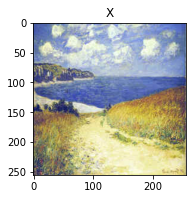

In [13]:
sample_X = next(iter_test_image_X)
sample_Y = next(iter_test_image_Y)
plt.subplot(121)
plt.title('X')
plt.imshow(deprocess(sample_X)[0])

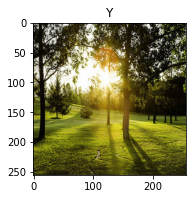

In [14]:
plt.subplot(121)
plt.title('Y')
plt.imshow(deprocess(sample_Y)[0])

In [15]:
image_buffer = ImageBuffer(buffer_size=BUFFER_SIZE)

In [16]:
training_steps = min(len(train_data_X), len(train_data_Y))

In [17]:
print(training_steps)

1072


In [18]:
Dx_optimizer = optim.Adam(Dx.parameters(), lr=0.0002, betas=(0.5, 0.999))
Dy_optimizer = optim.Adam(Dy.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_XtoY_optimizer = optim.Adam(G_XtoY.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_YtoX_optimizer = optim.Adam(G_YtoX.parameters(), lr=0.0002, betas=(0.5, 0.999))

def lambda_rule(epoch):
    lr = 1.0 - max(0, epoch + 1 - LR_DECAY_EPOCH) / float(LR_DECAY_EPOCH + 1)
    return lr

Dx_optimizer_scheduler = lr_scheduler.LambdaLR(Dx_optimizer, lr_lambda=lambda_rule)
Dy_optimizer_scheduler = lr_scheduler.LambdaLR(Dy_optimizer, lr_lambda=lambda_rule)
G_XtoY_optimizer_scheduler = lr_scheduler.LambdaLR(G_XtoY_optimizer, lr_lambda=lambda_rule)
G_YtoX_optimizer_scheduler = lr_scheduler.LambdaLR(G_YtoX_optimizer, lr_lambda=lambda_rule)


In [19]:
def discriminator_loss(real_image, generated_image):
    real_loss = (real_image - torch.FloatTensor(real_image.size()).uniform_(SOFT_REAL_LABEL_RANGE[0], 
                                                                           SOFT_REAL_LABEL_RANGE[1]).to(device)).pow(2).mean()
    fake_loss = (generated_image - torch.FloatTensor(generated_image.size()).uniform_(SOFT_FAKE_LABEL_RANGE[0], 
                                                                           SOFT_FAKE_LABEL_RANGE[1]).to(device)).pow(2).mean()
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

def discriminator_loss_test(real_image, generated_image):
    mse = torch.nn.MSELoss()
    real_loss = mse(real_image, torch.FloatTensor(real_image.size()).uniform_(SOFT_REAL_LABEL_RANGE[0], 
                                                                           SOFT_REAL_LABEL_RANGE[1]).to(device))
    fake_loss = mse(generated_image, torch.FloatTensor(generated_image.size()).uniform_(SOFT_FAKE_LABEL_RANGE[0], 
                                                                           SOFT_FAKE_LABEL_RANGE[1]).to(device))
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

def generator_loss(generated_image):
    loss =(generated_image - torch.FloatTensor(generated_image.size()).uniform_(SOFT_REAL_LABEL_RANGE[0], 
                                                                           SOFT_REAL_LABEL_RANGE[1]).to(device)).pow(2).mean()
    return loss

def generator_loss_test(generated_image):
    mse = torch.nn.MSELoss()
    loss = mse(generated_image, torch.FloatTensor(generated_image.size()).uniform_(SOFT_REAL_LABEL_RANGE[0], 
                                                                           SOFT_REAL_LABEL_RANGE[1]).to(device))
    return loss

def cycle_consistency_loss(real_image, cycled_image):
    loss = (real_image - cycled_image).abs().mean()
    return loss * LAMBDA

def cycle_consistency_loss_test(real_image, cycled_image):
    mae = torch.nn.L1Loss()
    loss = mae(real_image, cycled_image).abs().mean()
    return loss * LAMBDA

def identity_loss(real_image, generated_image):
    loss = (real_image - generated_image).abs().mean()
    return loss * 0.5 * LAMBDA

def identity_loss_test(real_image, generated_image):
    mae = torch.nn.L1Loss()
    loss = mae(real_image, generated_image).abs().mean()
    return loss * 0.5 * LAMBDA

In [20]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', DATASET, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'Dx_optimizer_scheduler': Dx_optimizer_scheduler.state_dict(),
    'Dy_optimizer_scheduler': Dy_optimizer_scheduler.state_dict(),
    'G_XtoY_optimizer_scheduler': G_XtoY_optimizer_scheduler.state_dict(),
    'G_YtoX_optimizer_scheduler': G_YtoX_optimizer_scheduler.state_dict(),
    'epoch': epoch
    }
    
    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

def save_models():
    state_dict = {
    'G_XtoY':G_XtoY,
    'G_YtoX':G_YtoX
    }
    save_path = os.path.join(checkpoint_path, 'model')
    torch.save(state_dict, checkpoint_path)


# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    Dx_optimizer_scheduler.load_state_dict(checkpoint['Dx_optimizer_scheduler'])
    Dy_optimizer_scheduler.load_state_dict(checkpoint['Dy_optimizer_scheduler'])
    G_XtoY_optimizer_scheduler.load_state_dict(checkpoint['G_XtoY_optimizer_scheduler'])
    G_YtoX_optimizer_scheduler.load_state_dict(checkpoint['G_YtoX_optimizer_scheduler'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 5 restored!!


In [21]:
def generate_images(model, test_input, img_name='img', step=0):
    prediction = model(test_input.to(device)).cpu().detach()
    plt.figure(figsize=(12, 12))

    display_list = [test_input, prediction]
    title = ['Input Image', 'Predicted Image']
    # Using the file writer, log the reshaped image.
    writer.add_image(os.path.join('train', img_name), denormalize(prediction)[0].numpy(), step)
    writer.flush()
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(deprocess(display_list[i])[0])
        plt.axis('off')
    plt.show()
    
def generate_test_images(model1, model2, test_input, img_name='img', step=0, show_result=False):
    '''
        Generate images and cycled images, then save them to tensorboard
    '''
    with torch.no_grad():
        prediction1 = model1(test_input.to(device))
        prediction2 = model2(prediction1)
        
    test_input = test_input.cpu()
    prediction1 = prediction1.cpu()
    prediction2 = prediction2.cpu()
    display_list = [test_input, prediction1, prediction2]
    title = ['Input Image', 'Predicted Image', 'Cycled Image']
    
    writer.add_image(os.path.join('test', img_name, ' original'), denormalize(test_input)[0].numpy(), step)
    writer.add_image(os.path.join('test', img_name, ' predicted'), denormalize(prediction1)[0].numpy(), step)
    writer.add_image(os.path.join('test', img_name, ' cycled'), denormalize(prediction2)[0].numpy(), step)
    writer.flush()
    
    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(deprocess(display_list[i])[0])
            plt.axis('off')
        plt.show()
        
def save_test_images(model1, model2, test_input, folder_name='img', step=0, save=False, show_result=False):
    '''
        Generate images and cycled images, then save them as jpg
    '''
    with torch.no_grad():
        prediction1 = model1(test_input.to(device))
        prediction2 = model2(prediction1)
        
    test_input = test_input.cpu()
    prediction1 = prediction1.cpu()
    prediction2 = prediction2.cpu()

    display_list = [test_input, prediction1, prediction2]
    title = ['original', 'predicted', 'cycled']
    figure_title = ['Input Image', 'Predicted Image', 'Cycled Image']
    
    base_folder = os.path.join(OUTPUT_PATH, folder_name)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    
    if save:
        for img, title in zip(display_list, title):
            save_folder = os.path.join(base_folder, title)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            img = deprocess(img)[0]
            plt.imsave(os.path.join(save_folder, '{}.jpg'.format(step)), img)
            
    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(figure_title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(deprocess(display_list[i])[0])
            plt.axis('off')
        plt.show()

In [22]:
# Write graph
writer.add_graph(G_XtoY, sample_X.to(device))
writer.add_graph(G_YtoX, sample_Y.to(device))
writer.add_graph(Dx, sample_X.to(device))
writer.add_graph(Dy, sample_Y.to(device))
writer.flush()

In [23]:
class TimeCounter():
    def __init__(self):
        self.init_time = time.time()
        self.stored_time = self.init_time
    def count(self, task_name="task"):
        current_time = time.time()
        consumed_time = current_time - self.stored_time
        self.stored_time = current_time
        print('Task {}, consume {} sec'.format(task_name, consumed_time))

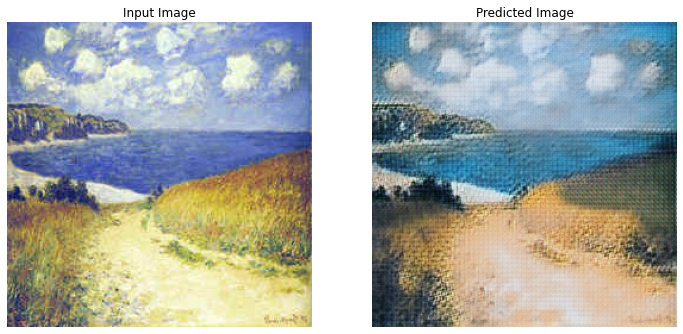

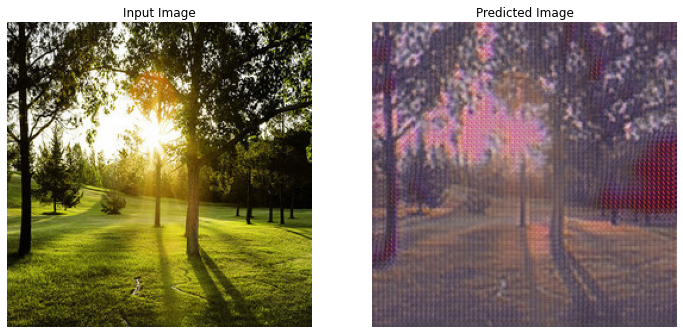

Saving checkpoint for epoch 5 at checkpoints\pytorch\monet2photo
Time taken for epoch 5 is 268.4517159461975 sec

Start of epoch 6
....................

In [ ]:
current_learning_rate = LR

trace = True
for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Average the losses of an epoch and write them.
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):
        
        # The probability to use previous images to train discriminators 
        replay_previous = True if REPLAY_PROB > random.random() else False

        real_image_X = iter_train_image_X.next().to(device)
        real_image_Y = iter_train_image_Y.next().to(device)
        
        # Generate fake images for discriminators
        fake_image_X = G_YtoX(real_image_Y).detach()
        fake_image_Y = G_XtoY(real_image_X).detach()
        
        image_buffer.add(real_image_X, fake_image_X, real_image_Y, fake_image_Y)

        Dx_optimizer.zero_grad()
        Dy_optimizer.zero_grad()
        if USE_BUFFER and replay_previous:
            # Get previous generated fake images
            buffered_images = image_buffer.sample()
            # Compute the discriminator loss using buffered images
            real_buffer_image_X = buffered_images.real_image_X
            fake_buffer_image_X = buffered_images.fake_image_X
            real_buffer_image_Y = buffered_images.real_image_Y
            fake_buffer_image_Y = buffered_images.fake_image_Y

            Dx_real_buffer = Dx(real_buffer_image_X)
            Dx_fake_buffer = Dx(fake_buffer_image_X)
            Dx_loss = discriminator_loss(Dx_real_buffer, Dx_fake_buffer)

            Dy_real_buffer = Dy(real_buffer_image_Y)
            Dy_fake_buffer = Dy(fake_buffer_image_Y)
            Dy_loss = discriminator_loss(Dy_real_buffer, Dy_fake_buffer)
        else:
            # Compute the discriminator loss using the latest fake images
            Dx_real = Dx(real_image_X)
            Dx_fake = Dx(fake_image_X)
            Dy_real = Dy(real_image_Y)
            Dy_fake = Dy(fake_image_Y)
            Dx_loss = discriminator_loss(Dx_real, Dx_fake)
            Dy_loss = discriminator_loss(Dy_real, Dy_fake)

        # ============================
        # Update discriminators
        # ============================
        Dx_loss.backward()
        Dy_loss.backward()
        Dx_optimizer.step()
        Dy_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        
        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)
        dis_fake_image_Y = Dy(fake_image_Y)
        dis_fake_image_X = Dx(fake_image_X)

        G_XtoY_loss = generator_loss(dis_fake_image_Y)
        G_YtoX_loss = generator_loss(dis_fake_image_X)
        # ============================
        # Compute the cycle consistency loss
        # ============================
        cycled_XtoYtoX = G_YtoX(fake_image_Y)
        cycled_YtoXtoY = G_XtoY(fake_image_X)
        cycled_XtoY_loss = cycle_consistency_loss(real_image_X, cycled_XtoYtoX)
        cycled_YtoX_loss = cycle_consistency_loss(real_image_Y, cycled_YtoXtoY)
        total_cycle_loss = cycled_XtoY_loss + cycled_YtoX_loss

        # ============================
        # Compute the identity loss
        # ============================
        same_image_Y = G_XtoY(real_image_Y)
        same_image_X = G_YtoX(real_image_X)
        identity_loss_for_YtoX = identity_loss(real_image_X, same_image_X)
        identity_loss_for_XtoY = identity_loss(real_image_Y, same_image_Y)

        # ============================
        # Combine all generator losses
        # ============================
        total_G_XtoY_loss = G_XtoY_loss + identity_loss_for_XtoY
        total_G_YtoX_loss = G_YtoX_loss + identity_loss_for_YtoX
        total_G_losses = total_G_XtoY_loss + total_G_YtoX_loss + total_cycle_loss
        # ============================
        # Update generators
        # ============================
        total_G_losses.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()
        
        # Add losses
        G_XtoY_loss_mean = G_XtoY_loss_mean + total_G_XtoY_loss.item() + total_cycle_loss.item()
        G_YtoX_loss_mean = G_YtoX_loss_mean + total_G_YtoX_loss.item() + total_cycle_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()
        
        if step % 10 == 0:
            print ('.', end='')
    
    # ============================
    # Write scalars at the end of an epoch
    # ============================
    writer.add_scalar('Loss/total_G_XtoY_loss', G_XtoY_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/total_G_YtoX_loss', G_YtoX_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/Dx_loss', Dx_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/Dy_loss', Dy_loss_mean / training_steps, epoch)
    writer.flush()
    # ============================
    # Update schedulers
    # ============================
    Dx_optimizer_scheduler.step()
    Dy_optimizer_scheduler.step()
    G_XtoY_optimizer_scheduler.step()
    G_YtoX_optimizer_scheduler.step()
    
    clear_output(wait=True)
    # Using a consistent image (sample_X) so that the progress of the model
    # is clearly visible.
    generate_images(G_XtoY, sample_X, img_name='sample_X', step=epoch)
    generate_images(G_YtoX, sample_Y, img_name='sample_Y', step=epoch)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        save_training_checkpoint(epoch)
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    gc.collect()

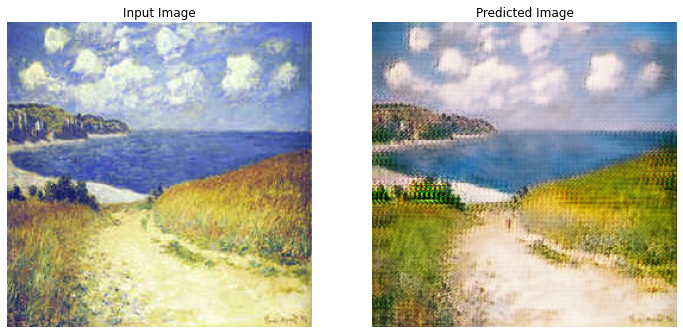

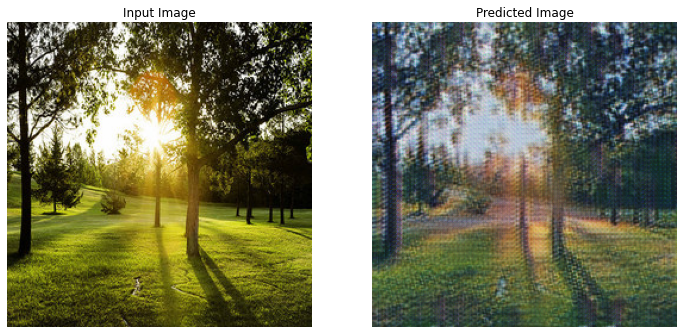

Saving checkpoint for epoch 5 at checkpoints\pytorch\monet2photo
Time taken for epoch 5 is 1795.0865664482117 sec

Start of epoch 6
..................................................................................

KeyboardInterrupt: 

In [24]:
current_learning_rate = LR

trace = True
for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Average the losses of an epoch and write them.
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):
        
        # The probability to use previous images to train discriminators 
        replay_previous = True if REPLAY_PROB > random.random() else False

        real_image_X = iter_train_image_X.next().to(device)
        real_image_Y = iter_train_image_Y.next().to(device)
        
        # Generate fake images for discriminators
        fake_image_X = G_YtoX(real_image_Y).detach()
        fake_image_Y = G_XtoY(real_image_X).detach()
        
        image_buffer.add(real_image_X, fake_image_X, real_image_Y, fake_image_Y)

        Dx_optimizer.zero_grad()
        Dy_optimizer.zero_grad()
        if USE_BUFFER and replay_previous:
            # Get previous generated fake images
            buffered_images = image_buffer.sample()
            # Compute the discriminator loss using buffered images
            real_buffer_image_X = buffered_images.real_image_X
            fake_buffer_image_X = buffered_images.fake_image_X
            real_buffer_image_Y = buffered_images.real_image_Y
            fake_buffer_image_Y = buffered_images.fake_image_Y

            Dx_real_buffer = Dx(real_buffer_image_X)
            Dx_fake_buffer = Dx(fake_buffer_image_X)
            Dx_loss = discriminator_loss(Dx_real_buffer, Dx_fake_buffer)

            Dy_real_buffer = Dy(real_buffer_image_Y)
            Dy_fake_buffer = Dy(fake_buffer_image_Y)
            Dy_loss = discriminator_loss(Dy_real_buffer, Dy_fake_buffer)
        else:
            # Compute the discriminator loss using the latest fake images
            Dx_real = Dx(real_image_X)
            Dx_fake = Dx(fake_image_X)
            Dy_real = Dy(real_image_Y)
            Dy_fake = Dy(fake_image_Y)
            Dx_loss = discriminator_loss(Dx_real, Dx_fake)
            Dy_loss = discriminator_loss(Dy_real, Dy_fake)

        # ============================
        # Update discriminators
        # ============================
        Dx_loss.backward()
        Dy_loss.backward()
        Dx_optimizer.step()
        Dy_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        
        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)
        dis_fake_image_Y = Dy(fake_image_Y)
        dis_fake_image_X = Dx(fake_image_X)

        G_XtoY_loss = generator_loss(dis_fake_image_Y)
        G_YtoX_loss = generator_loss(dis_fake_image_X)
        # ============================
        # Compute the cycle consistency loss
        # ============================
        cycled_XtoYtoX = G_YtoX(fake_image_Y)
        cycled_YtoXtoY = G_XtoY(fake_image_X)
        cycled_XtoY_loss = cycle_consistency_loss(real_image_X, cycled_XtoYtoX)
        cycled_YtoX_loss = cycle_consistency_loss(real_image_Y, cycled_YtoXtoY)
        total_cycle_loss = cycled_XtoY_loss + cycled_YtoX_loss

        # ============================
        # Compute the identity loss
        # ============================
        same_image_Y = G_XtoY(real_image_Y)
        same_image_X = G_YtoX(real_image_X)
        identity_loss_for_YtoX = identity_loss(real_image_X, same_image_X)
        identity_loss_for_XtoY = identity_loss(real_image_Y, same_image_Y)

        # ============================
        # Combine all generator losses
        # ============================
        total_G_XtoY_loss = G_XtoY_loss + identity_loss_for_XtoY
        total_G_YtoX_loss = G_YtoX_loss + identity_loss_for_YtoX
        total_G_losses = total_G_XtoY_loss + total_G_YtoX_loss + total_cycle_loss
        # ============================
        # Update generators
        # ============================
        total_G_losses.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()
        
        # Add losses
        G_XtoY_loss_mean = G_XtoY_loss_mean + total_G_XtoY_loss.item() + total_cycle_loss.item()
        G_YtoX_loss_mean = G_YtoX_loss_mean + total_G_YtoX_loss.item() + total_cycle_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()
        
        if step % 10 == 0:
            print ('.', end='')
    
    # ============================
    # Write scalars at the end of an epoch
    # ============================
    writer.add_scalar('Loss/total_G_XtoY_loss', G_XtoY_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/total_G_YtoX_loss', G_YtoX_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/Dx_loss', Dx_loss_mean / training_steps, epoch)
    writer.add_scalar('Loss/Dy_loss', Dy_loss_mean / training_steps, epoch)
    writer.flush()
    # ============================
    # Update schedulers
    # ============================
    Dx_optimizer_scheduler.step()
    Dy_optimizer_scheduler.step()
    G_XtoY_optimizer_scheduler.step()
    G_YtoX_optimizer_scheduler.step()
    
    clear_output(wait=True)
    # Using a consistent image (sample_X) so that the progress of the model
    # is clearly visible.
    generate_images(G_XtoY, sample_X, img_name='sample_X', step=epoch)
    generate_images(G_YtoX, sample_Y, img_name='sample_Y', step=epoch)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        save_training_checkpoint(epoch)
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    gc.collect()

In [ ]:
for step, image in enumerate(tqdm(test_image_loader_X)):
    
    show_result = True if (step + 1) >= len(test_data_X) else False
    
    # Save to tensorboard
    generate_test_images(G_XtoY, G_YtoX, image, img_name='test_XtoY', step=step, show_result=show_result)
    
    # Save image
    # save_test_images(G_XtoY, G_YtoX, image, folder_name='test_XtoY', step=step, save=True, show_result=show_result)

In [ ]:
for step, image in enumerate(tqdm(test_image_loader_Y)):
    
    show_result = True if (step + 1) >= len(test_data_Y) else False
    
#     Save to tensorboard
    generate_test_images(G_YtoX, G_XtoY, image, img_name='test_YtoX', step=step, show_result=show_result)
    
    # Save image
    # save_test_images(G_YtoX, G_XtoY, image, folder_name='test_YtoX', step=step, save=True, show_result=show_result)